In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')


In [53]:
#read data
df = pd.read_csv('loan_dataset 1.csv')

In [54]:
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [55]:
df.tail()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
44995,27.0,male,Associate,47971.0,6,RENT,15000.0,MEDICAL,15.66,0.31,3.0,645,No,1
44996,37.0,female,Associate,65800.0,17,RENT,9000.0,HOMEIMPROVEMENT,14.07,0.14,11.0,621,No,1
44997,33.0,male,Associate,56942.0,7,RENT,2771.0,DEBTCONSOLIDATION,10.02,0.05,10.0,668,No,1
44998,29.0,male,Bachelor,33164.0,4,RENT,12000.0,EDUCATION,13.23,0.36,6.0,604,No,1
44999,24.0,male,High School,51609.0,1,RENT,6665.0,DEBTCONSOLIDATION,17.05,0.13,3.0,628,No,1


In [56]:
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [57]:
df.isnull().sum()

person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64

In [58]:
columns_to_winsorize = [
    'person_age',
    'person_income',
    'person_emp_exp',
    'loan_amnt',
    'loan_int_rate',
    'loan_percent_income',
    'cb_person_cred_hist_length',
    'credit_score'
]


In [59]:
def wisker(col):
    q1, q3 = np.percentile(col.dropna(), [25, 75])  
    iqr = q3 - q1
    lw = q1 - 1.5 * iqr
    uw = q3 + 1.5 * iqr
    return lw, uw

def count_outliers(col, lw, uw):
    return ((col < lw) | (col > uw)).sum()

for col in columns_to_winsorize:
    if col in df.columns:
        lw, uw = wisker(df[col])
        outliers_before = count_outliers(df[col], lw, uw)
        print(f"Column: {col}")
        print(f"  Lower whisker (lw): {lw}")
        print(f"  Upper whisker (uw): {uw}")
        print(f"  Outliers BEFORE winsorization: {outliers_before}")

        # Apply winsorization
        df[col] = np.where(df[col] < lw, lw, df[col])
        df[col] = np.where(df[col] > uw, uw, df[col])

        outliers_after = count_outliers(df[col], lw, uw)
        print(f"  Outliers AFTER winsorization: {outliers_after}\n")


Column: person_age
  Lower whisker (lw): 15.0
  Upper whisker (uw): 39.0
  Outliers BEFORE winsorization: 2188
  Outliers AFTER winsorization: 0

Column: person_income
  Lower whisker (lw): -25673.875
  Upper whisker (uw): 168667.125
  Outliers BEFORE winsorization: 2218
  Outliers AFTER winsorization: 0

Column: person_emp_exp
  Lower whisker (lw): -9.5
  Upper whisker (uw): 18.5
  Outliers BEFORE winsorization: 1724
  Outliers AFTER winsorization: 0

Column: loan_amnt
  Lower whisker (lw): -5855.875
  Upper whisker (uw): 23093.125
  Outliers BEFORE winsorization: 2348
  Outliers AFTER winsorization: 0

Column: loan_int_rate
  Lower whisker (lw): 1.9899999999999993
  Upper whisker (uw): 19.59
  Outliers BEFORE winsorization: 124
  Outliers AFTER winsorization: 0

Column: loan_percent_income
  Lower whisker (lw): -0.10999999999999999
  Upper whisker (uw): 0.37
  Outliers BEFORE winsorization: 744
  Outliers AFTER winsorization: 0

Column: cb_person_cred_hist_length
  Lower whisker (lw)

In [60]:
print(f"Number of duplicate rows before dropping: {df.duplicated().sum()}")
df = df.drop_duplicates()
print(f"Number of duplicate rows after dropping: {df.duplicated().sum()}")
# there is no duplicates

Number of duplicate rows before dropping: 0
Number of duplicate rows after dropping: 0


In [61]:
# Count the number of unique values in each column
unique_counts = df.nunique()
print(unique_counts)

person_age                           20
person_gender                         2
person_education                      5
person_income                     31854
person_emp_exp                       20
person_home_ownership                 4
loan_amnt                          4191
loan_intent                           6
loan_int_rate                      1292
loan_percent_income                  38
cb_person_cred_hist_length           15
credit_score                        269
previous_loan_defaults_on_file        2
loan_status                           2
dtype: int64


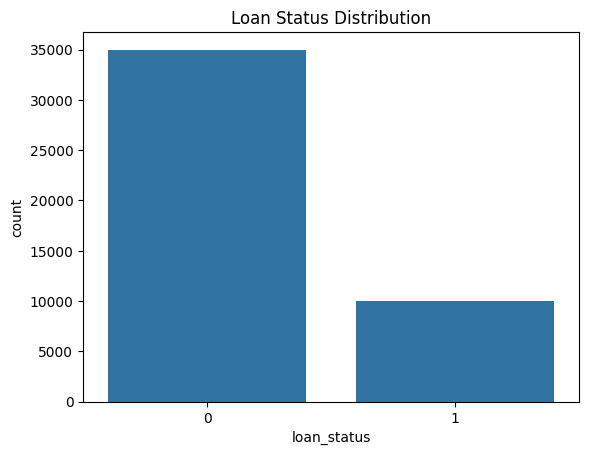

In [62]:
# Target distribution
sns.countplot(data=df, x='loan_status')
plt.title("Loan Status Distribution")
plt.show()

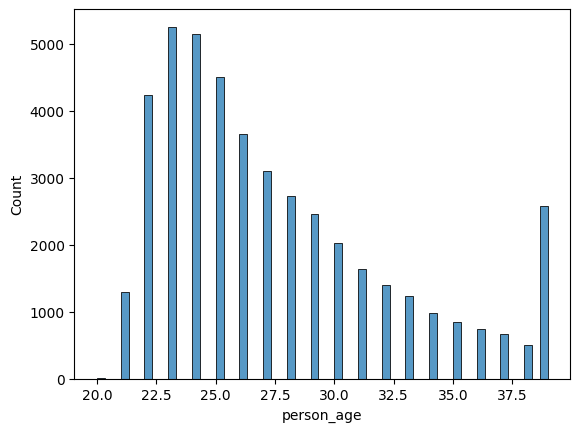

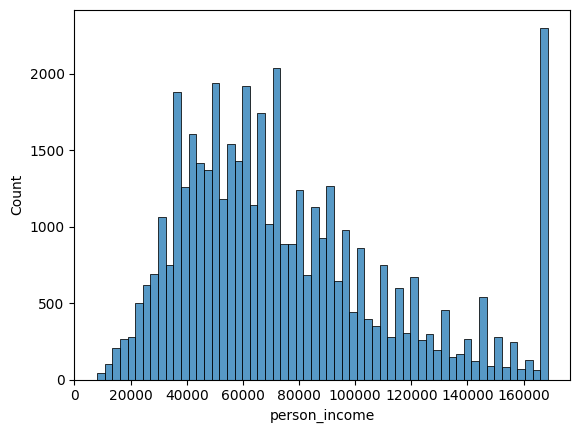

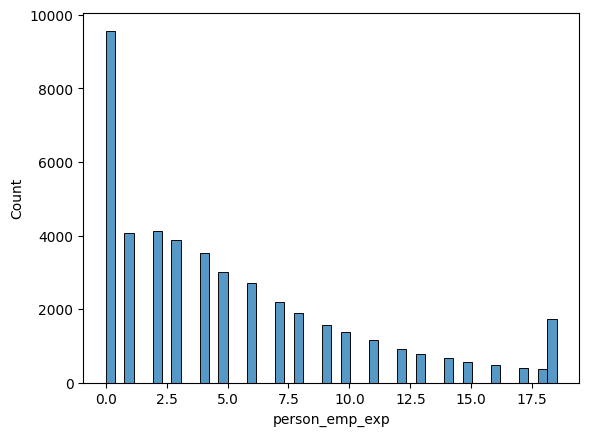

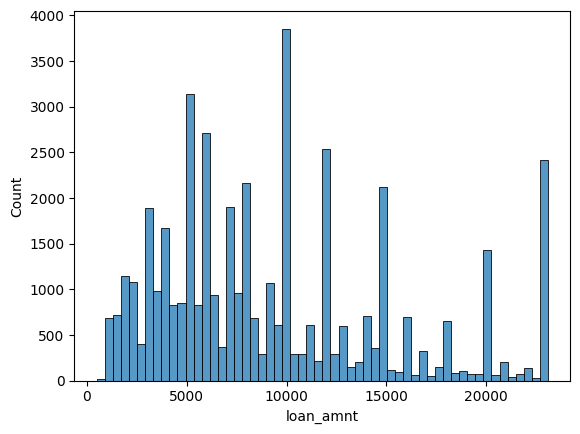

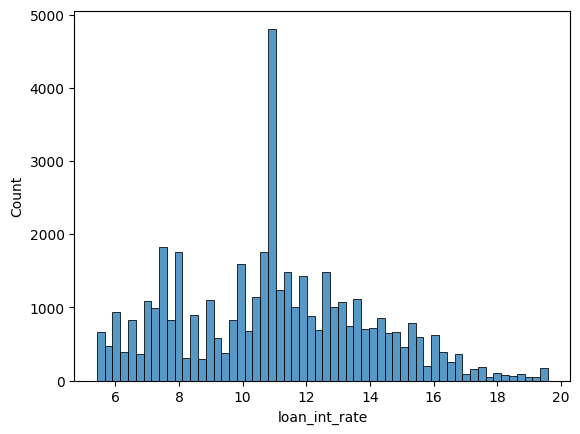

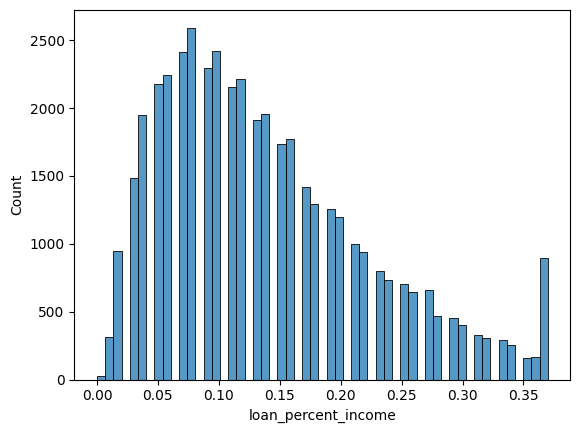

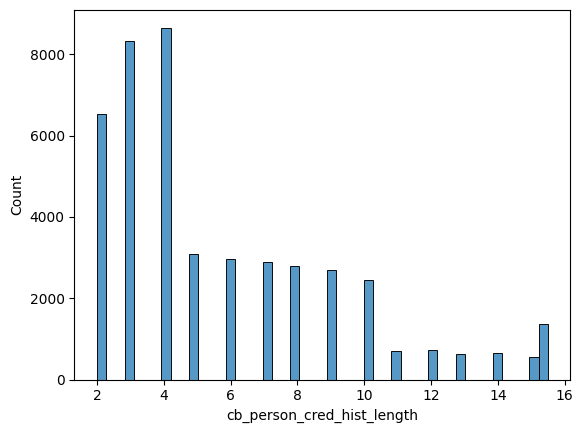

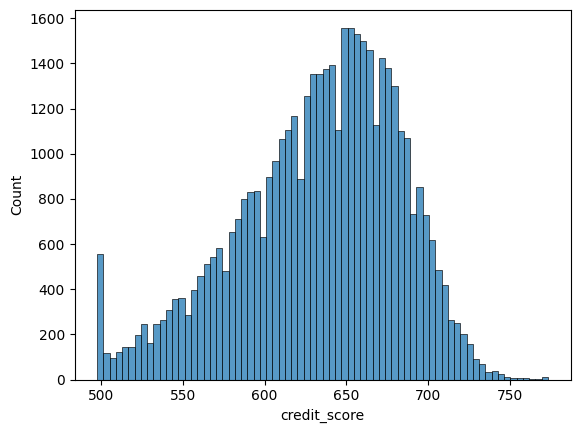

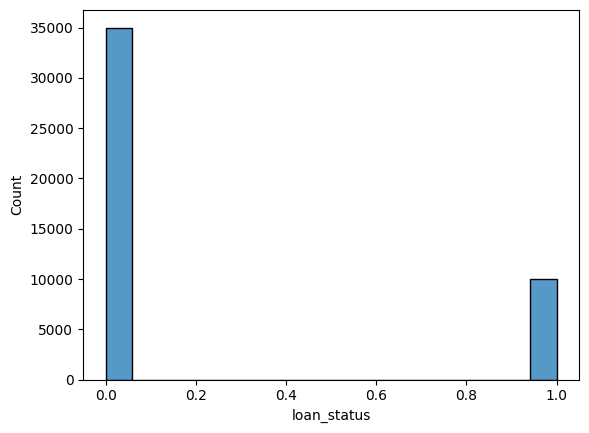

In [63]:
# histogram to understand data distribution
for i in df.select_dtypes(include= "number").columns:
    sns.histplot(data=df,x=i)
    plt.show()

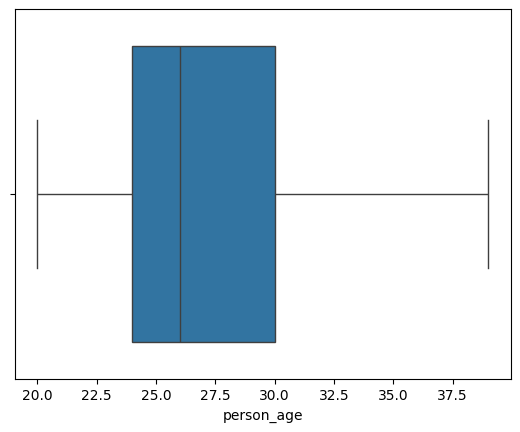

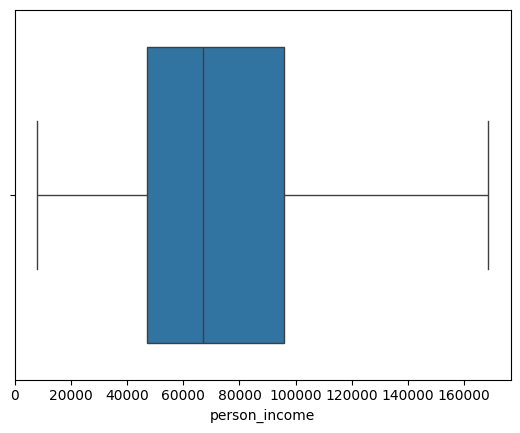

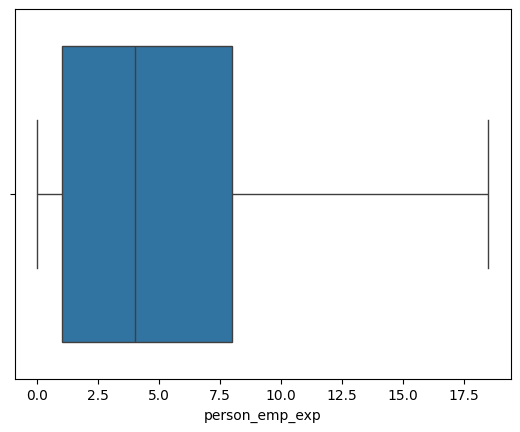

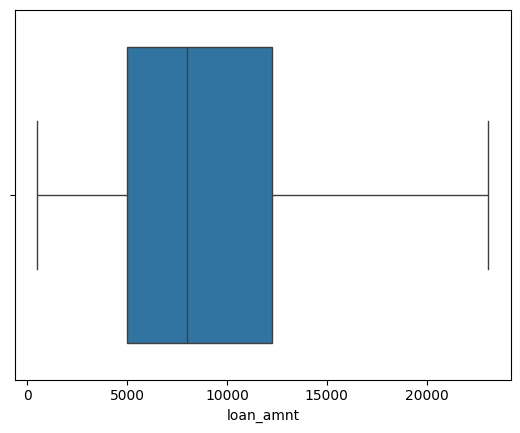

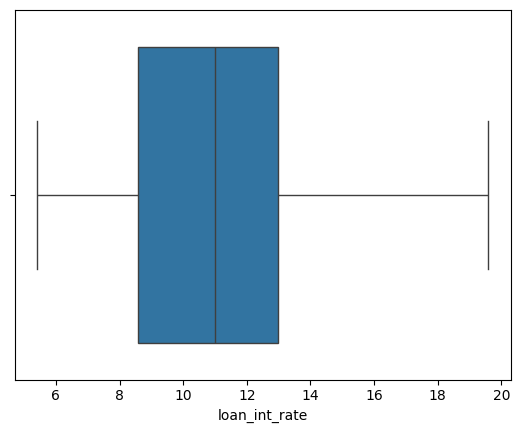

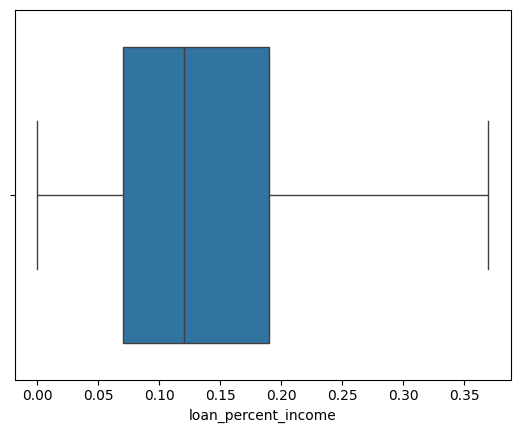

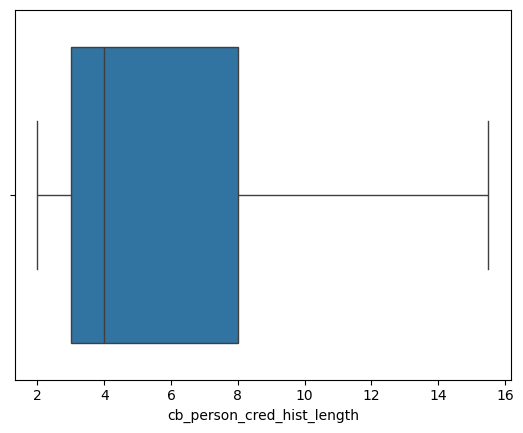

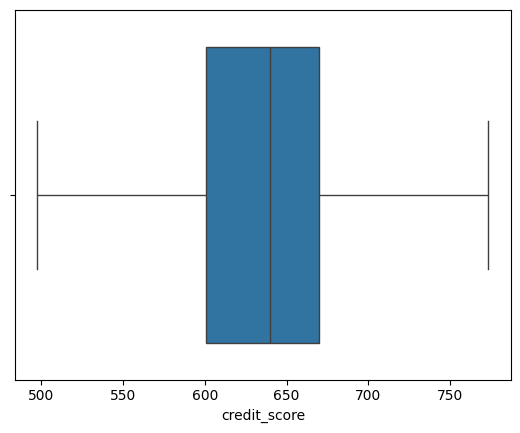

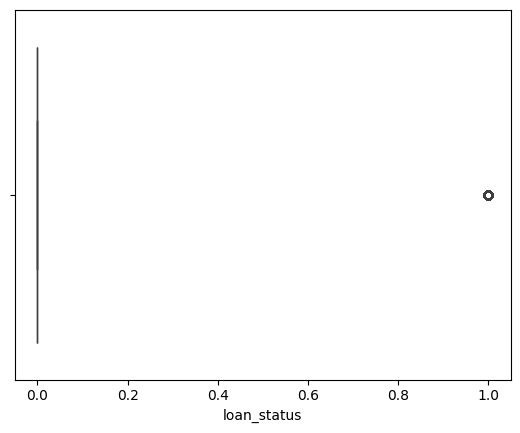

In [64]:
for i in df.select_dtypes(include= "number").columns:
  sns.boxplot(data=df,x=i)
  plt.show()

In [65]:
#scatter plot to understand the relationship
numeric_columns = df.select_dtypes(include = "number").columns.drop('loan_status')
print(numeric_columns)
print(df.shape)

Index(['person_age', 'person_income', 'person_emp_exp', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'credit_score'],
      dtype='object')
(45000, 14)


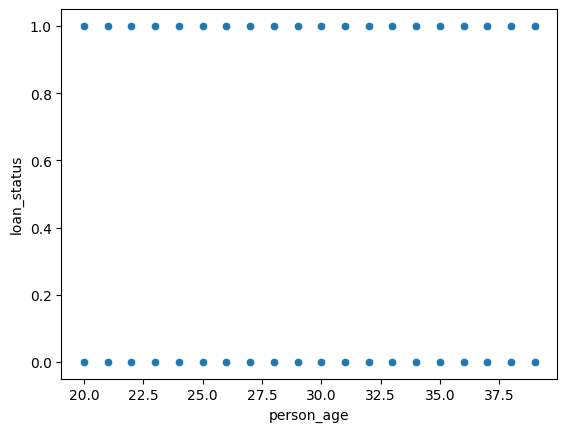

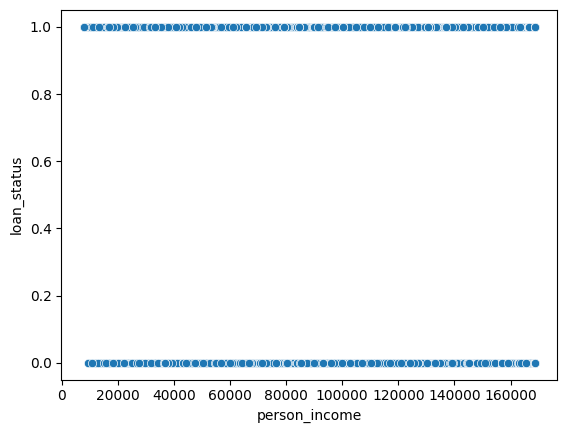

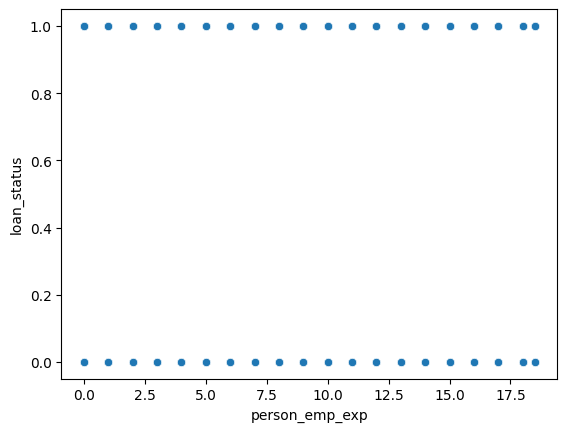

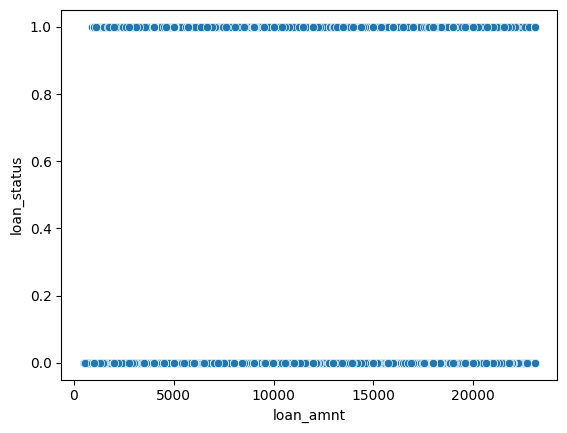

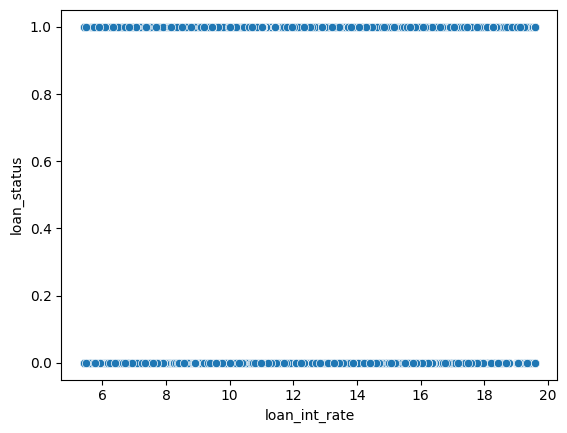

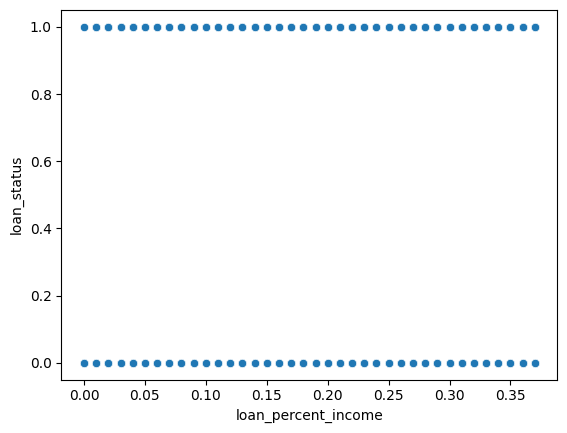

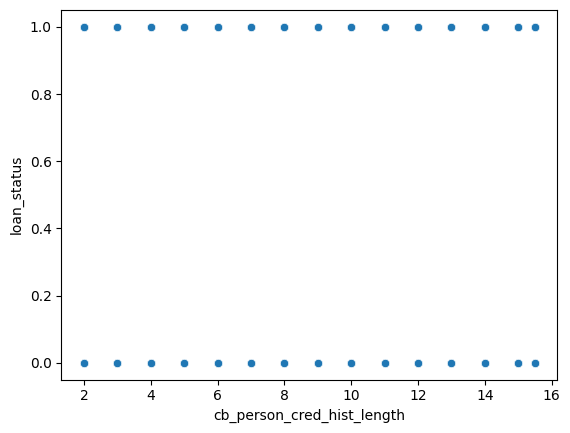

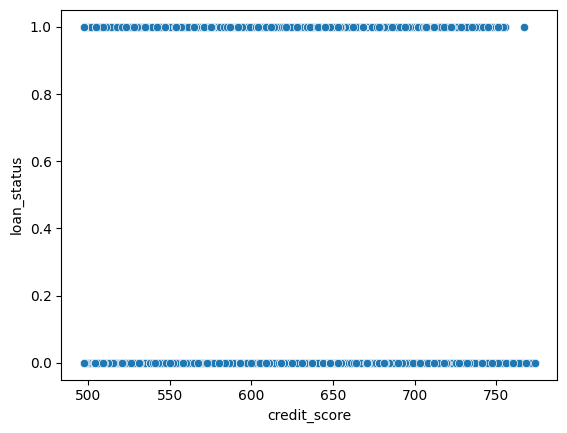

In [66]:
for i in numeric_columns:
    sns.scatterplot(data=df, x =i,y = 'loan_status' )
    plt.show()

In [67]:
#correlation with heatmap to interpret the relation and multicolinearity
s = df.select_dtypes(include ="number").corr()
s

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
person_age,1.000000,0.132808,0.936465,0.055983,0.015167,-0.047160,0.874753,0.168519,-0.025667
person_income,0.132808,1.000000,0.116176,0.411985,-0.016266,-0.357582,0.101592,0.026481,-0.249146
person_emp_exp,0.936465,0.116176,1.000000,0.047884,0.018210,-0.043028,0.831335,0.179116,-0.023626
loan_amnt,0.055983,0.411985,0.047884,1.000000,0.142671,0.612110,0.043463,0.009183,0.107306
loan_int_rate,0.015167,-0.016266,0.018210,0.142671,1.000000,0.127736,0.018906,0.011606,0.331851
loan_percent_income,-0.047160,-0.357582,-0.043028,0.612110,0.127736,1.000000,-0.032709,-0.011436,0.384660
cb_person_cred_hist_length,0.874753,0.101592,0.831335,0.043463,0.018906,-0.032709,1.000000,0.151711,-0.017596
credit_score,0.168519,0.026481,0.179116,0.009183,0.011606,-0.011436,0.151711,1.000000,-0.007680
loan_status,-0.025667,-0.249146,-0.023626,0.107306,0.331851,0.384660,-0.017596,-0.007680,1.000000


<Axes: >

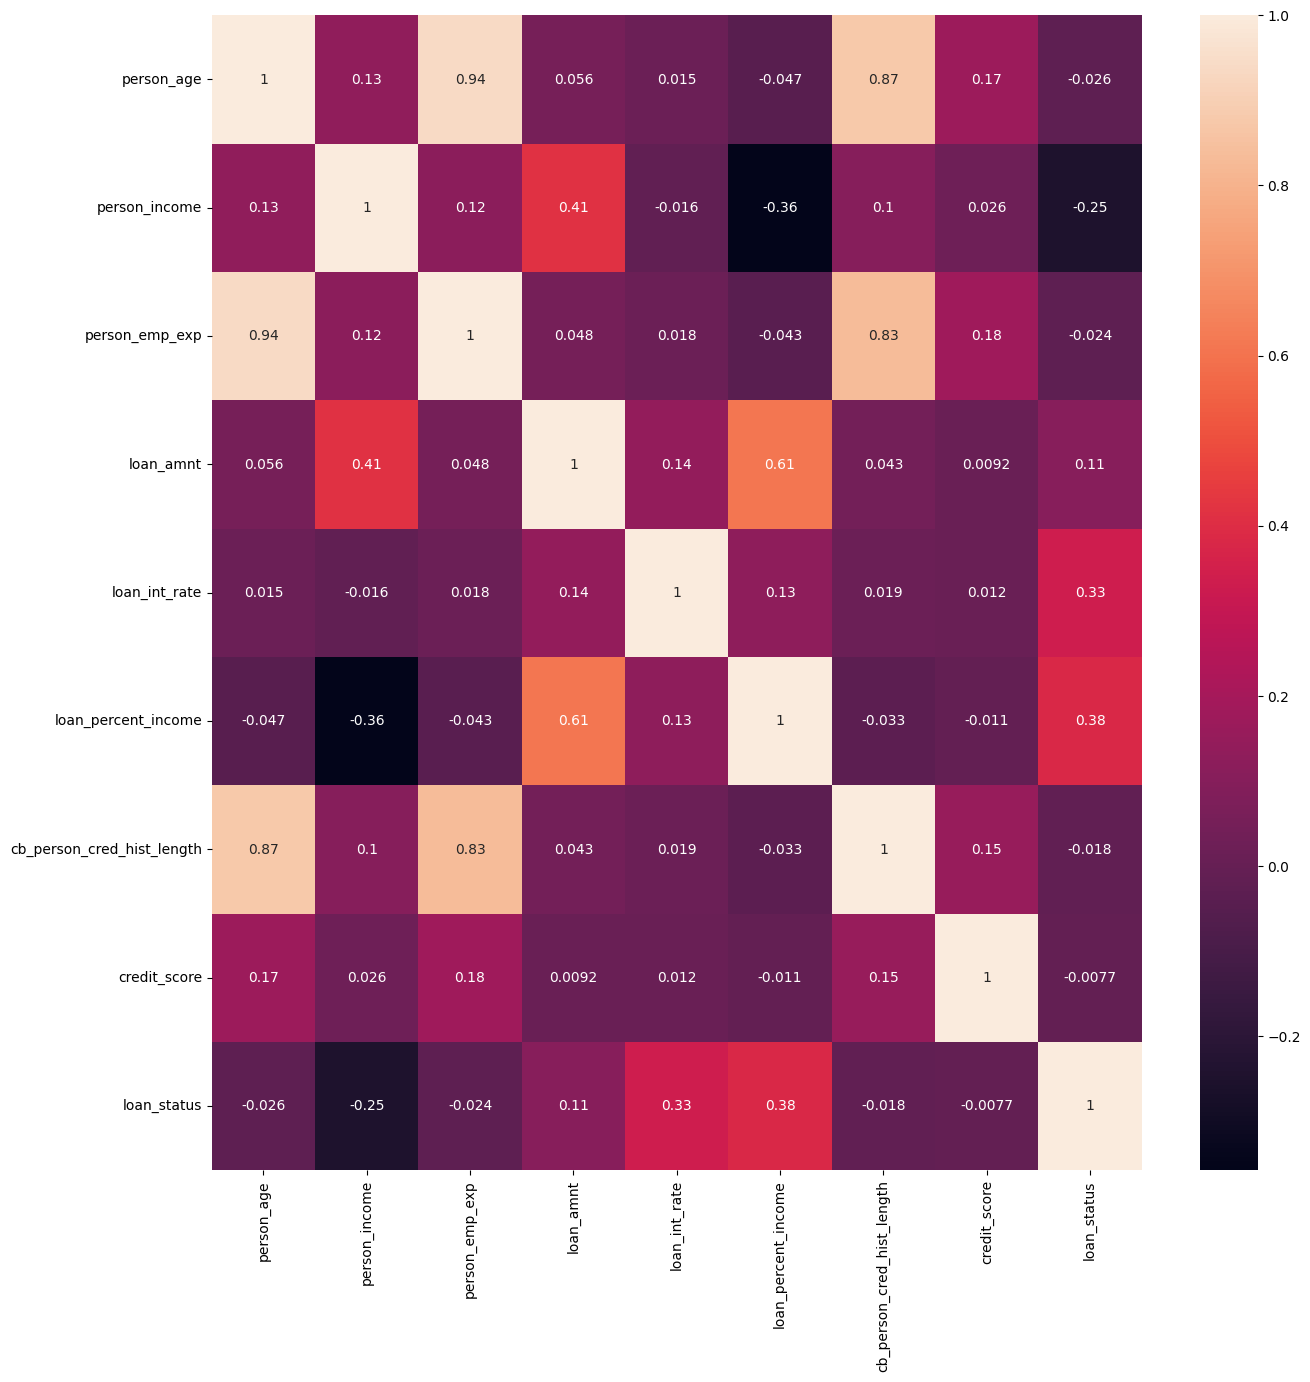

In [68]:
plt.figure(figsize=(15,15))
sns.heatmap(s,annot = True)

In [69]:
# Fill missing categorical with mode
for col in df.select_dtypes(include='object').columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Fill missing numerical with mean
for col in df.select_dtypes(exclude='object').drop('loan_status', axis=1).columns:
    df[col].fillna(df[col].mean(), inplace=True)

In [70]:
le = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = le.fit_transform(df[col])


In [71]:
#using head to show the data after encoding it
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,0,4,71948.0,0.0,3,23093.125,4,16.02,0.37,3.0,561.0,0,1
1,21.0,0,3,12282.0,0.0,2,1000.000,1,11.14,0.08,2.0,504.0,1,0
2,25.0,0,3,12438.0,3.0,0,5500.000,3,12.87,0.37,3.0,635.0,0,1
3,23.0,0,1,79753.0,0.0,3,23093.125,3,15.23,0.37,2.0,675.0,0,1
4,24.0,1,4,66135.0,1.0,3,23093.125,3,14.27,0.37,4.0,586.0,0,1


In [72]:
#splitting the data into 2 parts, training and testing. for the models that we're going to use
X = df.drop('loan_status', axis=1)
y = df['loan_status']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

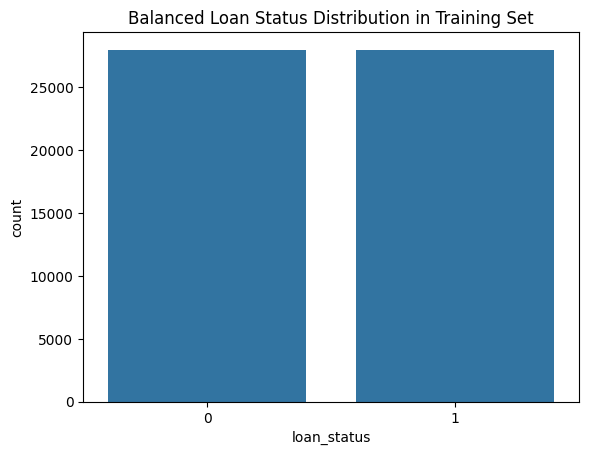

In [78]:
# Apply SMOTE only to the training set
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
#visualize the balance of the training set
sns.countplot(x=y_train_bal)
plt.title("Balanced Loan Status Distribution in Training Set")
plt.show()
# Define classifiers            
        

In [74]:
#initializing the models that we're going to use
models = {
    'KNN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, min_samples_split=10, min_samples_leaf=5),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=15),
    'SVC': SVC(probability=True),
    'Naive Bayes': GaussianNB()
}


Model: KNN
Training Accuracy: 0.9252
Testing Accuracy: 0.8918
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      7000
           1       0.77      0.72      0.75      2000

    accuracy                           0.89      9000
   macro avg       0.85      0.83      0.84      9000
weighted avg       0.89      0.89      0.89      9000

Confusion Matrix (Test):
[[6579  421]
 [ 553 1447]]

Model: Logistic Regression
Training Accuracy: 0.8907
Testing Accuracy: 0.8974
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      7000
           1       0.78      0.75      0.77      2000

    accuracy                           0.90      9000
   macro avg       0.85      0.85      0.85      9000
weighted avg       0.90      0.90      0.90      9000

Confusion Matrix (Test):
[[6571  429]
 [ 494 1506]]

Model: Decision Tree
Training Accuracy:

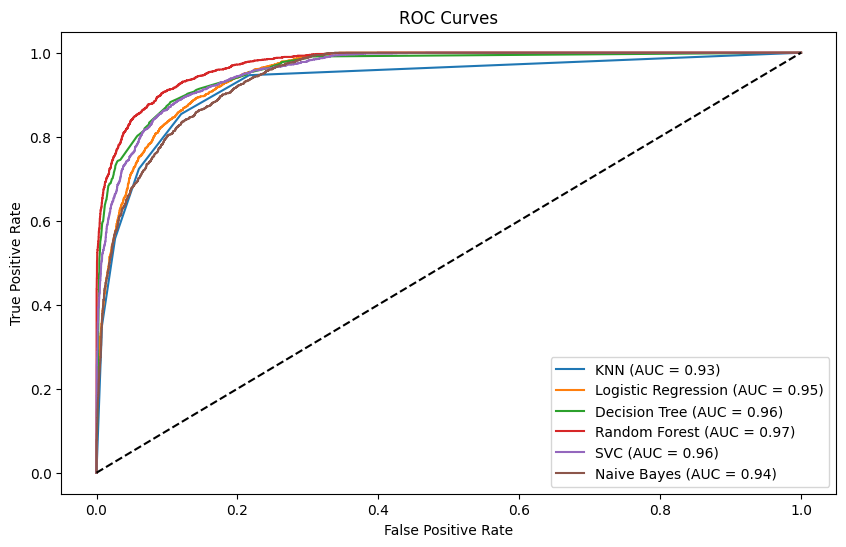

In [75]:
plt.figure(figsize=(10, 6))

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    train_accuracy = model.score(X_train, y_train)  # <-- Fix
    test_accuracy = model.score(X_test, y_test)

    print(f"\nModel: {name}")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Testing Accuracy: {test_accuracy:.4f}")
    print("Classification Report (Test):")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix (Test):")
    print(confusion_matrix(y_test, y_pred))

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()


In [76]:
# evaluating the models using cross validation for accuracy and generalization
print("5-Fold Cross-Validation Accuracy Scores:")
for name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=5)
    print(f"{name}: {scores.mean():.4f}")


5-Fold Cross-Validation Accuracy Scores:
KNN: 0.8875
Logistic Regression: 0.8903
Decision Tree: 0.9157
Random Forest: 0.9214
SVC: 0.9055
Naive Bayes: 0.7302


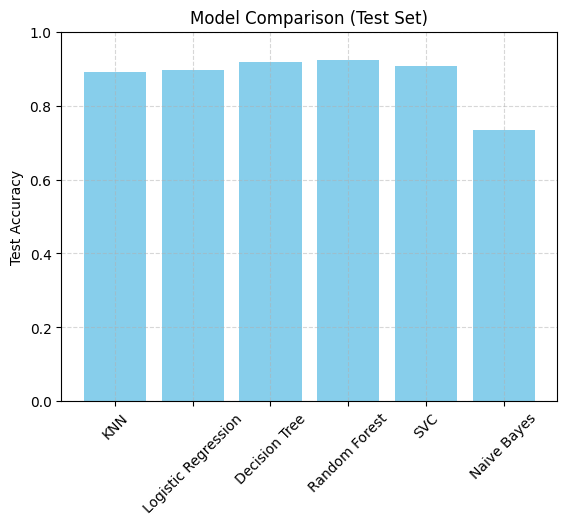

In [77]:
model_scores = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    model_scores[name] = score

plt.bar(model_scores.keys(), model_scores.values(), color='skyblue')
plt.ylabel("Test Accuracy")
plt.title("Model Comparison (Test Set)")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()